In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from astropy import units as u
import astropy.coordinates as coord
from mpl_toolkits import mplot3d
from sklearn.datasets import make_blobs
import seaborn as sns
import hdbscan
import math
import itertools
import pickle
from sklearn.preprocessing import StandardScaler

import time

In [3]:
#try it with UBC21 first
field_UBC21 = pd.read_csv('Data\\UBC21-result.csv')



mean_dr3 = pd.read_csv('Data\\oc_means_dr3.csv')
memb_dr3 = pd.read_csv('Data\\members_kept_2681_OCs.csv')


print(mean_dr3.columns)
print(memb_dr3.columns)
mean_dr3

Index(['oc', 'll', 'bb', 'nbKept', 'medPmra', 'sigPmra', 'medPmdec',
       'sigPmdec', 'medParallax', 'sigParallax', 'medianRV', 'errRV', 'nbRV',
       'ageNN'],
      dtype='object')
Index(['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       ...
       'bp_ssc_error3', 'rp_ssc_error0', 'rp_ssc_error1', 'rp_ssc_error2',
       'rp_ssc_error3', 'nu_eff', 'nu_eff_error',
       'phot_robust_bp_rp_excess_factor', 'previous_solution', 'cluster'],
      dtype='object', length=244)


,oc,ll,bb,nbKept,medPmra,sigPmra,medPmdec,sigPmdec,medParallax,sigParallax,medianRV,errRV,nbRV,ageNN
0,ASCC_108,74.398,6.056,256,-0.473,0.102,-1.715,0.112,0.869,0.042,-7.077,0.926,64,8.03
1,ASCC_127,112.400,4.238,117,7.472,0.216,-1.801,0.228,2.673,0.060,-13.272,0.603,38,7.26
2,ASCC_29,214.768,-0.100,69,-0.987,0.052,-1.034,0.071,0.999,0.034,23.494,1.804,20,7.97
3,ASCC_41,219.190,12.360,137,0.674,0.217,-3.945,0.226,3.394,0.104,-10.820,0.537,65,8.33
4,ASCC_67,294.558,0.683,24,-6.756,0.053,0.932,0.039,0.535,0.016,-1000.000,-1000.000,0,7.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,NGC_6259,341.981,-1.539,714,-1.035,0.118,-2.903,0.107,0.457,0.029,-33.418,0.503,54,8.43
2527,NGC_869,134.624,-3.738,498,-0.653,0.106,-1.145,0.098,0.438,0.024,-62.164,1.165,7,7.18
2528,NGC_6067,329.736,-2.212,837,-1.964,0.116,-2.579,0.112,0.505,0.036,-38.991,0.501,76,8.10
2529,NGC_6705,27.303,-2.772,1158,-1.548,0.137,-4.169,0.141,0.444,0.050,34.798,0.503,58,8.49


In [12]:
clust495 =memb_dr3.query('cluster == "UPK_495"')

np.max(clust495['phot_g_mean_mag'])

17.428593

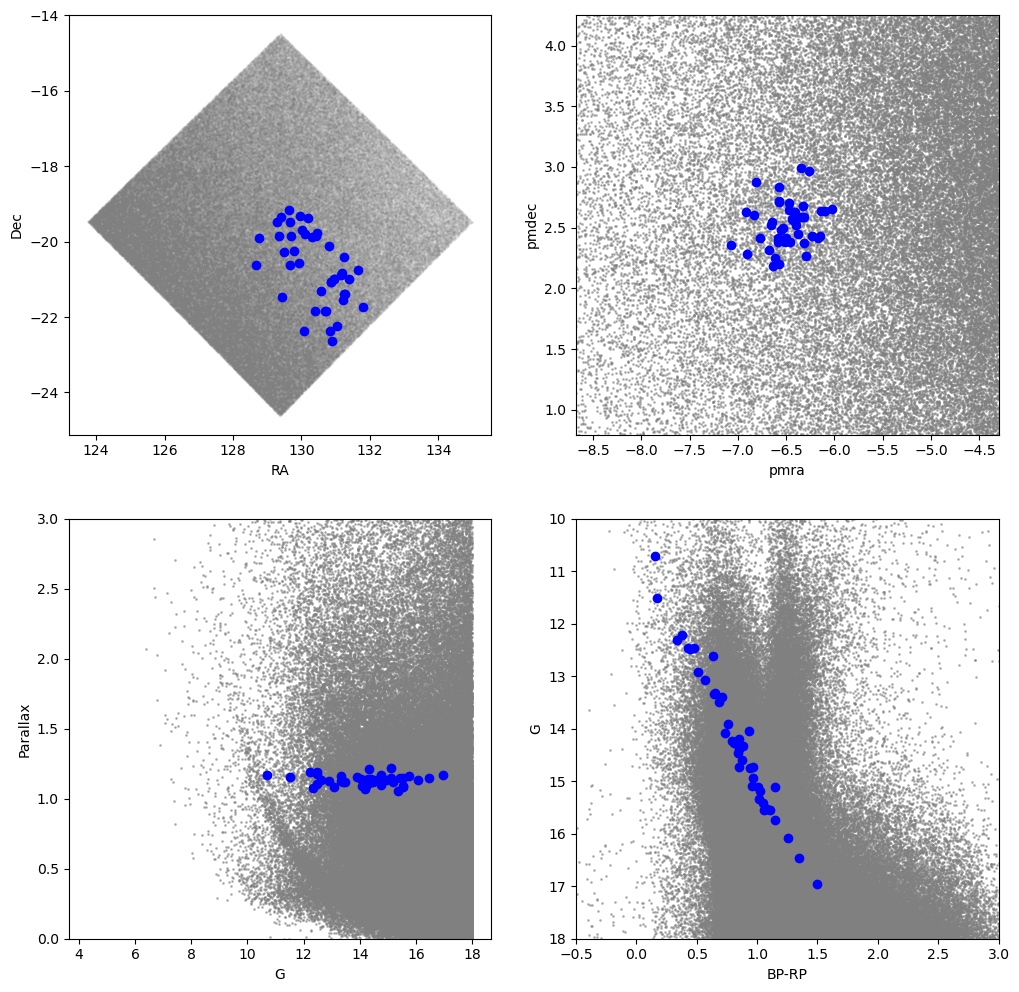

In [7]:
clust_mean = mean_dr3.query('oc == "UBC_21"')
clust = memb_dr3.query('cluster == "UBC_21"')
field = field_UBC21.query('phot_g_mean_mag < 18')


plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.scatter(field['ra'], field['dec'], c='grey', s = 0.1 , alpha=0.1)
plt.scatter(clust['ra'], clust['dec'], c = 'blue')
plt.xlabel('RA')
plt.ylabel('Dec')

plt.subplot(2,2,2)
plt.scatter(field['pmra'], field['pmdec'], c='grey', s = 1 , alpha=0.5)
plt.scatter(clust['pmra'], clust['pmdec'], c = 'blue')
plt.xlim((clust_mean['medPmra'] - 10*clust_mean['sigPmra']).min(), (clust_mean['medPmra'] + 10*clust_mean['sigPmra']).max())
plt.ylim((clust_mean['medPmdec'] - 10*clust_mean['sigPmdec']).min(), (clust_mean['medPmdec'] + 10*clust_mean['sigPmdec']).max())
plt.xlabel('pmra')
plt.ylabel('pmdec')

plt.subplot(2,2,3)
plt.scatter(field['phot_g_mean_mag'], field['parallax'], c='grey', s = 1 , alpha=0.5)
plt.scatter(clust['phot_g_mean_mag'], clust['parallax'], c = 'blue')
plt.ylim(0,3)
plt.xlabel('G')
plt.ylabel('Parallax')

plt.subplot(2,2,4)
plt.scatter(field['bp_rp'], field['phot_g_mean_mag'], c='grey', s = 1 , alpha=0.5)
plt.scatter(clust['bp_rp'], clust['phot_g_mean_mag'], c = 'blue')
plt.ylim(10,18)
plt.xlim(-0.5,3)
plt.xlabel('BP-RP')
plt.ylabel('G')
plt.gca().invert_yaxis()
plt.show()


In [83]:
#find OC members, field stars and density

num_oc = np.array([])
field_dens = np.array([])
magnitudecutUBC21 = np.arange(12, np.max(clust['phot_g_mean_mag']) +1)

for i in magnitudecutUBC21:
    print(f'G <= {i}')
    print(f'\tOC members: {len(clust.query(f"phot_g_mean_mag <= {i}"))}')
    num_oc = np.append(num_oc, len(clust.query(f"phot_g_mean_mag <= {i}")))
    print(f'\tField stars: {len(field.query(f"phot_g_mean_mag <= {i}"))}')
    surface = np.abs(field.query(f"phot_g_mean_mag <= {i}")['ra'].max() - field.query(f"phot_g_mean_mag <= {i}")['ra'].min())*np.abs(field.query(f"phot_g_mean_mag <= {i}")['dec'].max() - field.query(f"phot_g_mean_mag <= {i}")['dec'].min())
    print(f'\t\t density = {np.round(len(field.query(f"phot_g_mean_mag <= {i}"))/surface)} stars/deg^2')
    field_dens = np.append(field_dens, np.round(len(field.query(f"phot_g_mean_mag <= {i}"))/surface))
    


G <= 12.0
	OC members: 2
	Field stars: 5850
		 density = 53.0 stars/deg^2
G <= 13.0
	OC members: 9
	Field stars: 13680
		 density = 122.0 stars/deg^2
G <= 14.0
	OC members: 15
	Field stars: 30195
		 density = 266.0 stars/deg^2
G <= 15.0
	OC members: 29
	Field stars: 64165
		 density = 566.0 stars/deg^2
G <= 16.0
	OC members: 39
	Field stars: 131949
		 density = 1161.0 stars/deg^2
G <= 17.0
	OC members: 42
	Field stars: 247445
		 density = 2176.0 stars/deg^2


In [94]:
#perform the clustering

fieldclust = field_UBC21.dropna()

#do cuts on parallax and proper motion

fieldclust = field_UBC21.query('phot_g_mean_mag < 12').query('0 < parallax < 7').query('-30 < pmra < 30').query('-30 < pmdec < 30')

#scale the data

data_scaled = StandardScaler().fit_transform(np.array(fieldclust[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]))
scaled_frame = pd.DataFrame(data_scaled, columns = ['ra', 'dec', 'parallax', 'pmra', 'pmdec'], dtype=float)

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=10, cluster_selection_epsilon=0.5, cluster_selection_method='leaf')
clusterer.fit(scaled_frame)

print(f'Number of clusters: {len(np.unique(clusterer.labels_))-1}')
for i in np.unique(clusterer.labels_):
    if i == -1: continue
    print(f'\tGroup {i}: {len(clusterer.labels_[clusterer.labels_ == i])}')


Number of clusters: 11
	Group 0: 2
	Group 1: 2
	Group 2: 3
	Group 3: 2
	Group 4: 3
	Group 5: 2
	Group 6: 3
	Group 7: 2
	Group 8: 2
	Group 9: 4
	Group 10: 2128


C:\Users\dlp96\AppData\Local\Temp\ipykernel_19952\3487926943.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('inferno', len(np.unique(clusterer.labels_)))
C:\Users\dlp96\AppData\Local\Temp\ipykernel_19952\3487926943.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.array(fieldclust['ra'][index]), np.array(fieldclust['dec'][index]), c=colors(i), s = 0.5)


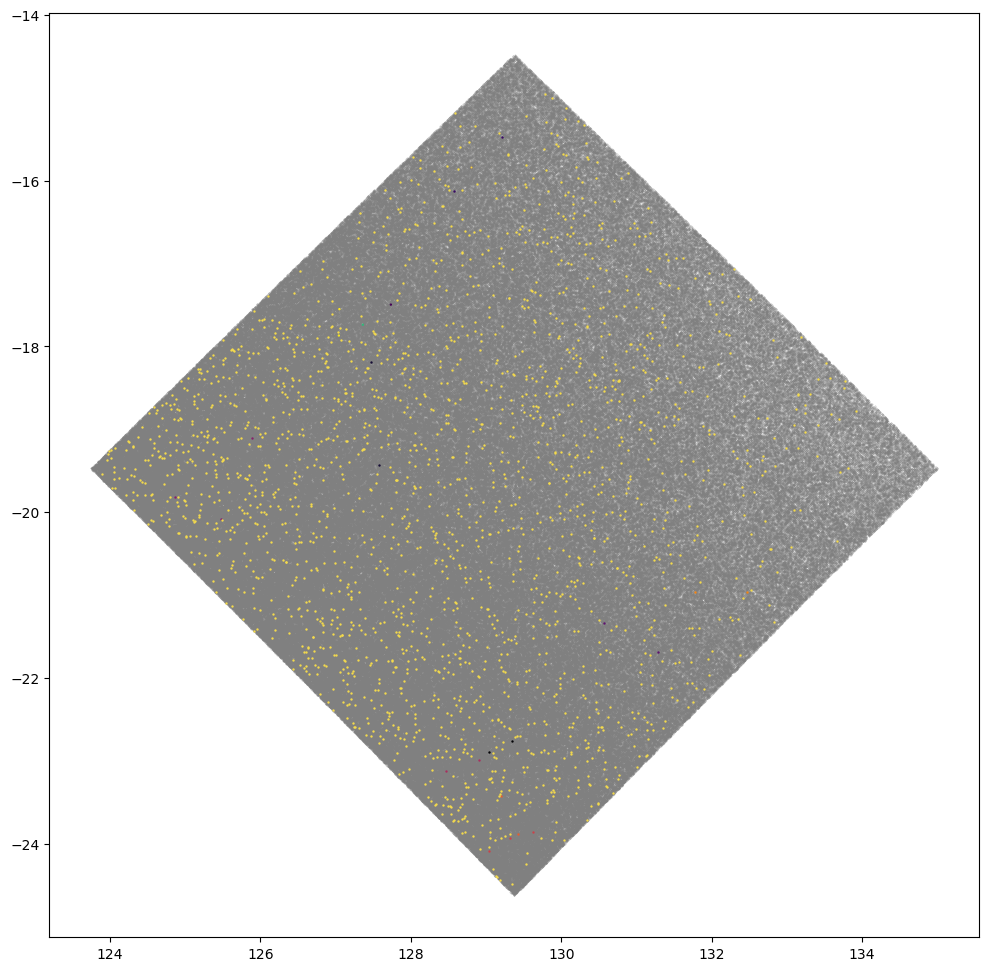

In [96]:
#plot the clusters

# for i in np.unique(clusterer.labels_):
#     if i == -1: continue
#     print(i)
#     index = clusterer.labels_ == i
#     plt.scatter(field_UBC21['ra'], field_UBC21['dec'], c='grey', s = 0.1 , alpha=0.5)
#     plt.scatter(np.array(field_UBC21['ra'][index]), np.array(field_UBC21['dec'][index]), c = 'blue', s =0.5)
#     plt.show()

#plot the clusters with the OC members
plt.figure(figsize=(12,12))
plt.scatter(field_UBC21['ra'], field_UBC21['dec'], c='grey', s = 0.1 , alpha=0.5)
colors = plt.cm.get_cmap('inferno', len(np.unique(clusterer.labels_)))

for i in np.unique(clusterer.labels_):
    if i == -1: continue
    index = clusterer.labels_ == i
    plt.scatter(np.array(fieldclust['ra'][index]), np.array(fieldclust['dec'][index]), c=colors(i), s = 0.5)
plt.show()



In [87]:
#check if UBC21 is detected in the groups

field_ID = np.array(field_UBC21['source_id'])
clust_ID = np.array(clust.query('phot_g_mean_mag <=12')['source_id'])

print(f'OC members: {len(clust_ID)}')
for i in np.unique(clusterer.labels_):
    if i == -1: continue
    index = clusterer.labels_ == i
    group_ID = np.array(fieldclust['source_id'][index])
    crossmatch = np.array([True if x in clust_ID else False for x in group_ID])
    print(f'Group {i}:')
    print(f'\t # members: {len(group_ID)}')
    print(f'\t # crossmatched stars: {np.sum(crossmatch)}')  


OC members: 2
Group 0:
	 # members: 2
	 # crossmatched stars: 0
Group 1:
	 # members: 2
	 # crossmatched stars: 0
Group 2:
	 # members: 3
	 # crossmatched stars: 0
Group 3:
	 # members: 2
	 # crossmatched stars: 0
Group 4:
	 # members: 3
	 # crossmatched stars: 0
Group 5:
	 # members: 2
	 # crossmatched stars: 0
Group 6:
	 # members: 3
	 # crossmatched stars: 0
Group 7:
	 # members: 2
	 # crossmatched stars: 0
Group 8:
	 # members: 2
	 # crossmatched stars: 0
Group 9:
	 # members: 4
	 # crossmatched stars: 0
Group 10:
	 # members: 2128
	 # crossmatched stars: 2


In [91]:
#automate the process to include magnitude dependance

for i in np.arange(12, 16, 1):
    print(f'G <= {i}')
    field = field_UBC21.query(f'phot_g_mean_mag < {i}')
    clust_ID = np.array(clust.query(f'phot_g_mean_mag <={i}')['source_id'])
    field_ID = np.array(field['source_id'])
    print(f'\tOC members: {len(clust_ID)}')
    field = field.dropna().query('phot_g_mean_mag <= @i ').query('0 < parallax < 7').query('-30 < pmra < 30').query('-30 < pmdec < 30')
    print(f'\tField stars: {len(field)}')
    #scale the data
    data_scaled = StandardScaler().fit_transform(np.array(field[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]))
    scaled_frame = pd.DataFrame(data_scaled, columns = ['ra', 'dec', 'parallax', 'pmra', 'pmdec'], dtype=float)
    #determine a minimum cluster size and cluster the data

    clustersize = min(10, len(clust.query(f'phot_g_mean_mag<= {i}')))
    clusterer = hdbscan.HDBSCAN(min_cluster_size=clustersize, min_samples=10, cluster_selection_method = 'leaf')
    clusterer.fit(scaled_frame)
    print(f'\t# HDBscan Groups: {len(np.unique(clusterer.labels_))-1}')
    complete_crossmatch = np.array([])
    group_members = np.array([])
    for j in np.unique(clusterer.labels_):
        if j == -1: continue
        group_idex = clusterer.labels_ == j
        group_ID = np.array(field['source_id'][group_idex])
        crossmatch = np.array([True if x in clust_ID else False for x in group_ID])

        if np.sum(crossmatch) > 0:
            members = len(group_ID)
            crossmatch_amount = np.sum(crossmatch)
            print(f'\t\tGroup {j}:')
            print(f'\t\t\t # members: {members}')
            print(f'\t\t\t # crossmatched stars: {crossmatch_amount}')
            complete_crossmatch = np.append(complete_crossmatch, crossmatch_amount)
            group_members = np.append(group_members, members)
        elif np.sum(crossmatch) == 0:
            complete_crossmatch = np.append(complete_crossmatch, 0)
            group_members = np.append(group_members, 1)

    crossmatched_total = np.sum(complete_crossmatch)
    total_members = np.sum(group_members)
    
    purity = crossmatched_total/total_members
    completeness = crossmatched_total/len(clust_ID)
    print(f'\tPurity: {purity}')
    print(f'\tCompleteness: {completeness}')

G <= 12.0
	OC members: 2
	Field stars: 5328
	# HDBscan Groups: 46
G <= 13.0
	OC members: 9
	Field stars: 12771
	# HDBscan Groups: 21
		Group 0:
			 # members: 9
			 # crossmatched stars: 2
G <= 14.0
	OC members: 15
	Field stars: 28609
	# HDBscan Groups: 15
G <= 15.0
	OC members: 29
	Field stars: 61386
	# HDBscan Groups: 51
		Group 0:
			 # members: 18
			 # crossmatched stars: 9
		Group 1:
			 # members: 31
			 # crossmatched stars: 10
G <= 16.0
	OC members: 39
	Field stars: 126855
	# HDBscan Groups: 73
		Group 1:
			 # members: 48
			 # crossmatched stars: 16
		Group 3:
			 # members: 12
			 # crossmatched stars: 7
G <= 17.0
	OC members: 42
	Field stars: 237951
	# HDBscan Groups: 139
		Group 5:
			 # members: 46
			 # crossmatched stars: 17
		Group 6:
			 # members: 14
			 # crossmatched stars: 4
